In [1]:
import datetime
import time
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics


from statsmodels.compat.pandas import deprecate_kwarg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# additive decompose a contrived additive time series
from random import randrange
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tenso

221 celle


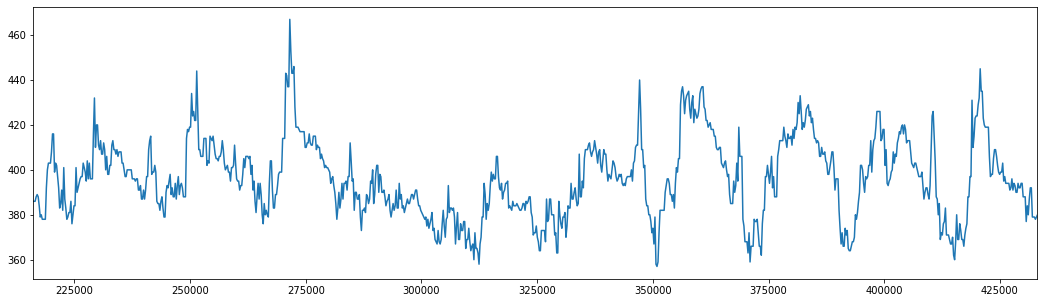

In [3]:
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv', index_col = 0, 
                   header=0, parse_dates=True)

agg_by_cell = data.groupby(by = ['cell_num'])
print(len(agg_by_cell), 'celle')
serie_dati = agg_by_cell.get_group('496-1255')
plt.figure(figsize = (18,5))
#one_cell.set_index('date')
serie_dati['nr_people'][977:1960].plot()
plt.show()

In [4]:
serie_dati = serie_dati.iloc[::4, :]

In [5]:
counter = 0
dict2data = {}
error_list = []

print(counter)
counter +=1
dates4dec = []
cell_values = []

for index, row in serie_dati.iterrows():
    
        date = row['date']
        h = str(row['hours'])
   
        h = h.split('.')
    
        if len(h[0])<2:
            h = h[1]+h[0]
        else: 
            h = h[0]
   
        minutes = str(row['minutes'])
        m = ''
        minutes = minutes.split('.')
        if len(minutes[0])<2: 
            m = minutes[0] +'0'
        else: 
            m = minutes[0]
        #print(date, h, m)
        data_f = date+' '+h+':'+m+':'+'00'
        #print(data_f)
        cell_values.append(row['nr_people'])
        dates4dec.append(data_f)  

0


In [26]:
dict_i = {'ds': dates4dec, 'y':cell_values}
data4deco = pd.DataFrame(dict_i, index=None, columns=None)  
data4deco.head()

data4deco['ds'] = pd.to_datetime(data4deco['ds'])
data4deco = data4deco.set_index('ds')
data4deco.head()

decomp = decompose(data4deco['y'], period=96)

trend = decomp.trend.values
print(len(trend))
seasonal = decomp.seasonal.values
print(len(seasonal))
residual = decomp.resid.values
#print(residual.head(2))

2952
2952


In [27]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
def get_forcast_per_component(series, st_in, st_out, train_test_size):
    
    # split into samples
    X, y = split_sequence(series, st_in, st_out)

    train_X, test_X = X[:train_test_size], X[train_test_size:]
    train_y, test_y = y[:train_test_size], y[train_test_size:]

    # define model
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=st_in)) 
    model.add(Dense(st_out))

    model.compile(optimizer='adam', loss='mse' , metrics=[metrics.mae, 'accuracy'])

    # fit model
    model.fit(train_X, train_y, batch_size=64, epochs=200, verbose=2)
    
    # predict 
    predicted = []
    for i in range(len(test_X)):
        x_input = test_X[i].reshape(1, st_in)
        yhat = model.predict(x_input, verbose=0)
        
        #predicted.append(np.rint(yhat[0]))   
        predicted.append(np.around(yhat[0], decimals=1)) 
    predicted = np.array(predicted)
    return predicted

In [29]:
n_steps_in, n_steps_out = 2600, 12

forcasted_trend = get_forcast_per_component(trend, n_steps_in, n_steps_out, n_steps_in)
forcasted_residual = get_forcast_per_component(residual, n_steps_in, n_steps_out, n_steps_in)
forcasted_season = get_forcast_per_component(seasonal, n_steps_in, n_steps_out, n_steps_in)

Epoch 1/200
 - 0s - loss: 1025933.3739 - mean_absolute_error: 755.8966 - accuracy: 0.0000e+00
Epoch 2/200
 - 0s - loss: 179207.9443 - mean_absolute_error: 338.5862 - accuracy: 0.0000e+00
Epoch 3/200
 - 0s - loss: 113362.3433 - mean_absolute_error: 277.7085 - accuracy: 0.0000e+00
Epoch 4/200
 - 0s - loss: 68509.0888 - mean_absolute_error: 208.8661 - accuracy: 0.0000e+00
Epoch 5/200
 - 0s - loss: 55846.2078 - mean_absolute_error: 180.8329 - accuracy: 0.0000e+00
Epoch 6/200
 - 0s - loss: 41364.7811 - mean_absolute_error: 147.8849 - accuracy: 0.0000e+00
Epoch 7/200
 - 0s - loss: 29234.1392 - mean_absolute_error: 120.6299 - accuracy: 0.0000e+00
Epoch 8/200
 - 0s - loss: 18474.0662 - mean_absolute_error: 99.0406 - accuracy: 0.0000e+00
Epoch 9/200
 - 0s - loss: 9778.2328 - mean_absolute_error: 75.9410 - accuracy: 0.0000e+00
Epoch 10/200
 - 0s - loss: 4035.4983 - mean_absolute_error: 50.1388 - accuracy: 0.0000e+00
Epoch 11/200
 - 0s - loss: 1095.7392 - mean_absolute_error: 26.5417 - accuracy: 

Epoch 97/200
 - 0s - loss: 22.5445 - mean_absolute_error: 4.0754 - accuracy: 0.0176
Epoch 98/200
 - 0s - loss: 23.4583 - mean_absolute_error: 4.1595 - accuracy: 0.1378
Epoch 99/200
 - 0s - loss: 22.6936 - mean_absolute_error: 4.0882 - accuracy: 0.0088
Epoch 100/200
 - 0s - loss: 22.3762 - mean_absolute_error: 4.0703 - accuracy: 0.0528
Epoch 101/200
 - 0s - loss: 22.2071 - mean_absolute_error: 4.0461 - accuracy: 0.0616
Epoch 102/200
 - 0s - loss: 22.5285 - mean_absolute_error: 4.0793 - accuracy: 0.2023
Epoch 103/200
 - 0s - loss: 22.7334 - mean_absolute_error: 4.0546 - accuracy: 0.0000e+00
Epoch 104/200
 - 0s - loss: 22.7865 - mean_absolute_error: 4.0858 - accuracy: 0.1466
Epoch 105/200
 - 0s - loss: 22.5212 - mean_absolute_error: 4.0662 - accuracy: 0.0000e+00
Epoch 106/200
 - 0s - loss: 22.6834 - mean_absolute_error: 4.0435 - accuracy: 0.0762
Epoch 107/200
 - 0s - loss: 22.8619 - mean_absolute_error: 4.0957 - accuracy: 0.0000e+00
Epoch 108/200
 - 0s - loss: 22.7874 - mean_absolute_erro

 - 0s - loss: 16.5115 - mean_absolute_error: 3.4424 - accuracy: 0.0821
Epoch 194/200
 - 0s - loss: 16.4906 - mean_absolute_error: 3.4353 - accuracy: 0.0528
Epoch 195/200
 - 0s - loss: 16.1946 - mean_absolute_error: 3.4015 - accuracy: 0.0674
Epoch 196/200
 - 0s - loss: 16.5122 - mean_absolute_error: 3.4047 - accuracy: 0.0674
Epoch 197/200
 - 0s - loss: 16.6642 - mean_absolute_error: 3.4338 - accuracy: 0.0323
Epoch 198/200
 - 0s - loss: 16.0479 - mean_absolute_error: 3.3826 - accuracy: 0.0557
Epoch 199/200
 - 0s - loss: 16.3990 - mean_absolute_error: 3.4238 - accuracy: 0.0323
Epoch 200/200
 - 0s - loss: 16.3928 - mean_absolute_error: 3.3983 - accuracy: 0.0205
Epoch 1/200
 - 0s - loss: 8637.1440 - mean_absolute_error: 68.0778 - accuracy: 0.1261
Epoch 2/200
 - 0s - loss: 2110.9528 - mean_absolute_error: 35.6124 - accuracy: 0.1466
Epoch 3/200
 - 0s - loss: 1078.8508 - mean_absolute_error: 25.7761 - accuracy: 0.2493
Epoch 4/200
 - 0s - loss: 581.2559 - mean_absolute_error: 18.5959 - accuracy

 - 0s - loss: 45.3307 - mean_absolute_error: 4.6565 - accuracy: 0.8035
Epoch 92/200
 - 0s - loss: 44.7392 - mean_absolute_error: 4.5573 - accuracy: 0.7771
Epoch 93/200
 - 0s - loss: 57.5865 - mean_absolute_error: 4.9055 - accuracy: 0.7625
Epoch 94/200
 - 0s - loss: 49.6871 - mean_absolute_error: 4.7480 - accuracy: 0.7801
Epoch 95/200
 - 0s - loss: 45.7507 - mean_absolute_error: 4.6534 - accuracy: 0.7566
Epoch 96/200
 - 0s - loss: 44.4285 - mean_absolute_error: 4.4756 - accuracy: 0.7595
Epoch 97/200
 - 0s - loss: 48.0007 - mean_absolute_error: 4.6700 - accuracy: 0.7830
Epoch 98/200
 - 0s - loss: 42.2621 - mean_absolute_error: 4.4678 - accuracy: 0.8094
Epoch 99/200
 - 0s - loss: 37.9531 - mean_absolute_error: 4.3347 - accuracy: 0.7713
Epoch 100/200
 - 0s - loss: 34.7255 - mean_absolute_error: 4.2438 - accuracy: 0.8182
Epoch 101/200
 - 0s - loss: 31.1331 - mean_absolute_error: 3.9924 - accuracy: 0.8035
Epoch 102/200
 - 0s - loss: 34.5201 - mean_absolute_error: 4.1651 - accuracy: 0.7654
Ep

 - 0s - loss: 8.7202 - mean_absolute_error: 1.9506 - accuracy: 0.9120
Epoch 189/200
 - 0s - loss: 9.8119 - mean_absolute_error: 2.1149 - accuracy: 0.8944
Epoch 190/200
 - 0s - loss: 9.8699 - mean_absolute_error: 2.1261 - accuracy: 0.8974
Epoch 191/200
 - 0s - loss: 9.2445 - mean_absolute_error: 2.0939 - accuracy: 0.9150
Epoch 192/200
 - 0s - loss: 7.7798 - mean_absolute_error: 1.9433 - accuracy: 0.8827
Epoch 193/200
 - 0s - loss: 8.7745 - mean_absolute_error: 1.9751 - accuracy: 0.9208
Epoch 194/200
 - 0s - loss: 8.7557 - mean_absolute_error: 1.9756 - accuracy: 0.9150
Epoch 195/200
 - 0s - loss: 8.6270 - mean_absolute_error: 1.9704 - accuracy: 0.9208
Epoch 196/200
 - 0s - loss: 8.8590 - mean_absolute_error: 1.9843 - accuracy: 0.9003
Epoch 197/200
 - 0s - loss: 9.9482 - mean_absolute_error: 2.0654 - accuracy: 0.9413
Epoch 198/200
 - 0s - loss: 10.1220 - mean_absolute_error: 2.1074 - accuracy: 0.9003
Epoch 199/200
 - 0s - loss: 9.7372 - mean_absolute_error: 2.0384 - accuracy: 0.9032
Epoch

 - 0s - loss: 27.1950 - mean_absolute_error: 4.2152 - accuracy: 0.6276
Epoch 87/200
 - 0s - loss: 22.7503 - mean_absolute_error: 3.7297 - accuracy: 0.6188
Epoch 88/200
 - 0s - loss: 14.8918 - mean_absolute_error: 3.0711 - accuracy: 0.6422
Epoch 89/200
 - 0s - loss: 11.1945 - mean_absolute_error: 2.5986 - accuracy: 0.7067
Epoch 90/200
 - 0s - loss: 9.5751 - mean_absolute_error: 2.3890 - accuracy: 0.6921
Epoch 91/200
 - 0s - loss: 8.6004 - mean_absolute_error: 2.2779 - accuracy: 0.7243
Epoch 92/200
 - 0s - loss: 7.2295 - mean_absolute_error: 2.1134 - accuracy: 0.7419
Epoch 93/200
 - 0s - loss: 5.6887 - mean_absolute_error: 1.8590 - accuracy: 0.7097
Epoch 94/200
 - 0s - loss: 5.3842 - mean_absolute_error: 1.7980 - accuracy: 0.7918
Epoch 95/200
 - 0s - loss: 5.7214 - mean_absolute_error: 1.8294 - accuracy: 0.7566
Epoch 96/200
 - 0s - loss: 5.4809 - mean_absolute_error: 1.8207 - accuracy: 0.7683
Epoch 97/200
 - 0s - loss: 4.2922 - mean_absolute_error: 1.6347 - accuracy: 0.7566
Epoch 98/200


Epoch 184/200
 - 0s - loss: 9.0554 - mean_absolute_error: 2.3484 - accuracy: 0.6921
Epoch 185/200
 - 0s - loss: 10.0119 - mean_absolute_error: 2.3375 - accuracy: 0.6774
Epoch 186/200
 - 0s - loss: 9.7703 - mean_absolute_error: 2.4196 - accuracy: 0.7009
Epoch 187/200
 - 0s - loss: 7.5669 - mean_absolute_error: 2.1564 - accuracy: 0.7771
Epoch 188/200
 - 0s - loss: 8.6325 - mean_absolute_error: 2.2753 - accuracy: 0.6979
Epoch 189/200
 - 0s - loss: 6.8258 - mean_absolute_error: 2.0506 - accuracy: 0.7390
Epoch 190/200
 - 0s - loss: 5.6553 - mean_absolute_error: 1.8657 - accuracy: 0.7537
Epoch 191/200
 - 0s - loss: 4.6219 - mean_absolute_error: 1.7136 - accuracy: 0.8035
Epoch 192/200
 - 0s - loss: 4.5355 - mean_absolute_error: 1.6718 - accuracy: 0.7185
Epoch 193/200
 - 0s - loss: 6.9403 - mean_absolute_error: 2.0687 - accuracy: 0.7331
Epoch 194/200
 - 0s - loss: 8.5389 - mean_absolute_error: 2.2176 - accuracy: 0.6921
Epoch 195/200
 - 0s - loss: 10.8762 - mean_absolute_error: 2.3953 - accurac

In [36]:
print(forcasted_trend)
final_prediction = forcasted_trend + forcasted_residual + forcasted_season

[]


In [35]:
print(final_prediction)

[]


In [31]:
X, y = split_sequence(serie_dati['nr_people'].values, n_steps_in, n_steps_out) 

In [32]:
train_X, train_y = X[:n_steps_in], X[n_steps_in:]
train_y, test_y = y[:n_steps_in], y[n_steps_in:]

In [33]:
print(final_prediction.shape)
expected = test_y
print(expected.shape)

(0,)
(0, 12)
